In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.functional import adjust_contrast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import glob
from dataset import *

from einops import rearrange, repeat

/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

In [4]:
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Training the model

In [5]:
input_images = glob.glob('data/training/INPUT_IMAGES/*P1.5.JPG')

# hand selected
val_images = [] 
for x in [0,1,3,5,7,9]:
    val_images.append(glob.glob('data/validation/GT_IMAGES/*.jpg')[x])

test_images = glob.glob('data/validation/GT_IMAGES/*.jpg')

In [6]:
from ddpm.ddpm import *
from ddpm.ddpm_train import *

BATCH_SIZE=6
RESIZE_SIZE=32
IM_SIZE=32

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(size=(RESIZE_SIZE, RESIZE_SIZE)),
    #v2.RandomCrop(size=(IM_SIZE, IM_SIZE))
    ])

def hist_fix(im):
    new_im = im.clone()
    
    new_im[0] = (im[0] - torch.min(im[0])) / (torch.max(im[0])-torch.min(im[0]))
    new_im[1] = (im[1] - torch.min(im[1])) / (torch.max(im[1])-torch.min(im[1]))
    new_im[2] = (im[2] - torch.min(im[2])) / (torch.max(im[2])-torch.min(im[2]))

    return new_im

10:05:43 - INFO: Created a temporary directory at /tmp/tmpn3cxy3ra
10:05:43 - INFO: Writing /tmp/tmpn3cxy3ra/_remote_module_non_scriptable.py


In [7]:
train_dataset = CorrectionImageDataset(input_images, train=True, transform=transform)
val_dataset = CorrectionImageDataset(val_images, train=False, transform=transform)

/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


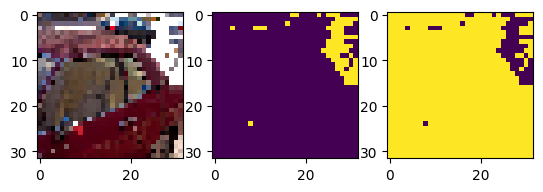

In [11]:
im, mask = val_dataset[0]

fig, axs = plt.subplots(1,3)
axs[0].imshow(hist_fix(im).permute((1,2,0)))
axs[1].imshow(mask.squeeze(0)) # Unknown region to generate
axs[2].imshow(~mask.squeeze(0)) # Known region

In [12]:
import scipy

In [13]:
def prepare_loaders():
        
    device = torch.device('cuda' if torch.cuda.is_available() else None)  
    print(f"Model will run on {device}")
    
    dataloader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=6, 
                            #persistent_workers=True,
                            pin_memory=True,
                           )
    
    valdataloader = DataLoader(val_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               #persistent_workers=True,
                               num_workers=6,
                               pin_memory=True)

    return dataloader, valdataloader 

In [14]:
dataloader, valdataloader  = prepare_loaders()

Model will run on cuda


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else None)  
print(f"Model will run on {device}")

Model will run on cuda


In [16]:
import warnings
warnings.filterwarnings('ignore')

# First

In [58]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=500, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=True, 
      metric='MSE',
      experiment_name='training_mse_32', 
      lr=0.0001,
      #max_steps=50
      )

03:55:13 - INFO: Starting epoch 1:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]
03:55:54 - INFO: Sampling 6 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:17<00:00, 29.15it/s]
03:56:11 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:56:11 - INFO: Starting epoch 2:
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [00:40<00:00, 14.66it/s, loss_func=0.00351]
03:56:51 - INFO: Starting epoch 3:
100%|█████████████████████

In [59]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=500, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=False, 
      metric='MSE',
      experiment_name='raw_training_mse_32', 
      lr=0.0001,
      #max_steps=50
      )

04:21:38 - INFO: Starting epoch 1:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]
04:22:21 - INFO: Sampling 6 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:19<00:00, 25.29it/s]
04:22:41 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
04:22:42 - INFO: Starting epoch 2:
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [00:43<00:00, 13.66it/s, loss_func=0.0111]
04:23:25 - INFO: Starting epoch 3:
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [00:44<00:00, 13.18it/s, loss_func=0.00826]
04:24:10 - INFO: Starting epoch 4:
100%|██████████████████████████████████████████████████████████████████████████

In [60]:
dataloader, valdataloader  = prepare_loaders()

Model will run on cuda


In [84]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=500, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=False, 
      metric='LPIPS',
      experiment_name='raw_lpips_32_2', 
      lr=0.0001,
      )

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


08:53:55 - INFO: Starting epoch 1:


Loading model from: /home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]
08:55:58 - INFO: Sampling 6 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:17<00:00, 28.62it/s]
08:56:16 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
08:56:16 - INFO: Starting epoch 2:
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [02:01<00:00,  4.85it/s, loss_func=0.00448]
08:58:18 - INFO: Starting epoch 3:
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [02:01<00:00,  4.85it/s, loss_func=0.00357]
09:00:19 - INFO: Starting epoch 4:
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [02:01

In [83]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=500, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=True, 
      metric='LPIPS',
      experiment_name='pretrained_lpips_32_2', 
      lr=0.0001,
      )

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


07:51:01 - INFO: Starting epoch 1:


Loading model from: /home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]
07:53:03 - INFO: Sampling 6 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:17<00:00, 29.31it/s]
07:53:20 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
07:53:20 - INFO: Starting epoch 2:
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [02:01<00:00,  4.85it/s, loss_func=0.00428]
07:55:22 - INFO: Starting epoch 3:
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [02:01<00:00,  4.86it/s, loss_func=0.00109]
07:57:23 - INFO: Starting epoch 4:
100%|████████████████████████████████████████████████████████████████████████████████████████████| 590/590 [02:02<

In [23]:

BATCH_SIZE=4
RESIZE_SIZE=64
IM_SIZE=64


transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(size=(RESIZE_SIZE, RESIZE_SIZE)),
    #v2.RandomCrop(size=(IM_SIZE, IM_SIZE))
    ])

In [17]:
def prepare_loaders():
        
    device = torch.device('cuda' if torch.cuda.is_available() else None)  
    print(f"Model will run on {device}")
    
    dataloader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=6, 
                            #persistent_workers=True,
                            pin_memory=True,
                           )
    
    valdataloader = DataLoader(val_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               #persistent_workers=True,
                               num_workers=6,
                               pin_memory=True)

    return dataloader, valdataloader 

In [18]:
val_images = [] 
for x in [0,1,3,5]:
    val_images.append(glob.glob('data/validation/GT_IMAGES/*.jpg')[x])

train_dataset = CorrectionImageDataset(input_images, train=True, transform=transform)
val_dataset = CorrectionImageDataset(val_images, train=False, transform=transform)

In [11]:
dataloader, valdataloader  = prepare_loaders()

Model will run on cuda


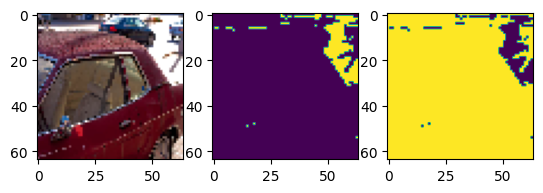

In [46]:
im, mask = val_dataset[0]

fig, axs = plt.subplots(1,3)
axs[0].imshow(hist_fix(im).permute((1,2,0)))
axs[1].imshow(mask) # Unknown region to generate
axs[2].imshow(~mask) # Known region

In [47]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=500, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=True, 
      metric='MSE',
      experiment_name='big_mse3', 
      lr=0.0001,
      max_steps=75
      )

11:27:07 - INFO: Starting epoch 1:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]
11:30:33 - INFO: Sampling 4 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [15:51<00:00,  1.91s/it]
11:46:25 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11:46:25 - INFO: Starting epoch 2:
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [03:24<00:00,  2.73s/it, loss_func=0.00791]
11:49:50 - INFO: Starting epoch 3:
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [03:24<00:00,  2.73s/it, loss_func=0.00121]
11:53:14 - INFO: Starting epoch 4:
100%|██████████████████████████████████████████████████████████████████████████

# Inference

In [60]:
test_dataset = CorrectionImageDataset(test_images, train=True, transform=transform)

In [61]:
model = UNet(img_size=IM_SIZE, c_in=3, c_out=3, 
             time_dim=256,channels=64, device=device).to(device)
diffusion = Diffusion(img_size=IM_SIZE, T=500, beta_start=1e-4, beta_end=0.02, device=device)
ckpt = torch.load("models/pretrained_lpips_32/weights-30.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

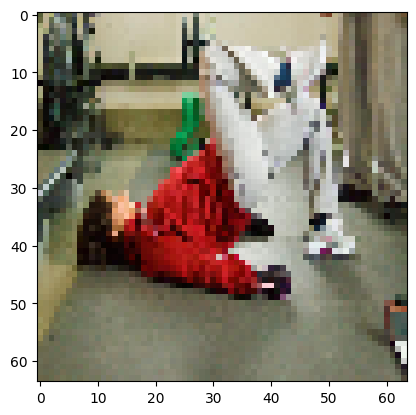

In [62]:
img_name = test_images[16] # 11 is fun, 16 is good, 23 nice , 24, 40, #135, 25, 79
# bad examples: 29, 72
image = Image.open(img_name)

img = transform(image)

# Get mask
bright_transform = A.RandomBrightnessContrast(p=1, brightness_limit=(0.2,0.2), contrast_limit=(0.1,0.1)) # Contrast limit has to be set otherwise it fluctuates
bright_image = torch.from_numpy(bright_transform(image=img.numpy())['image'])
mask = torch.mean(bright_image,0) >= 255 / 255

reconstructed_image = hist_fix(bright_image)

plt.imshow(img.permute((1,2,0)))

In [63]:
sampled_image = diffusion.p_sample_loop(reconstructed_image.unsqueeze(0).to(device), mask.unsqueeze(0).to(device), model,  batch_size=1)

10:38:59 - INFO: Sampling 1 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:27<00:00, 17.90it/s]


10:39:27 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


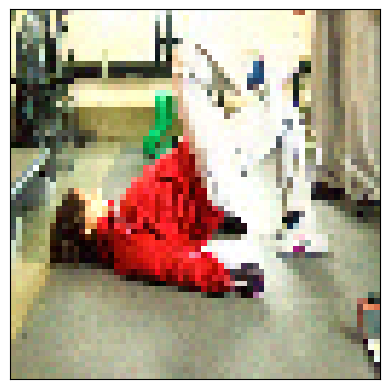

In [64]:
plt.imshow(sampled_image.squeeze(0).cpu().permute((1,2,0)))
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
#plt.savefig('lpips.png', bbox_inches='tight')

In [53]:
axs[0][0]

<Axes: >

10:18:08 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


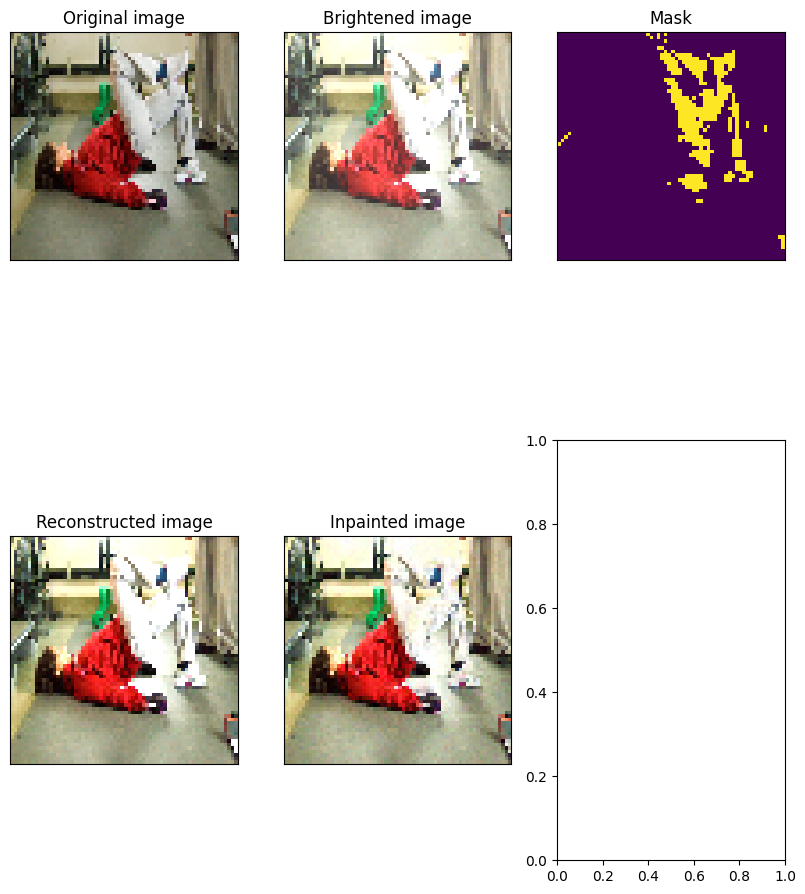

In [55]:
fig, axs = plt.subplots(2,3, figsize=(10,12))
axs[0][0].imshow(img.permute((1,2,0)))
axs[0][0].title.set_text('Original image')
axs[0][0].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
axs[0][1].title.set_text('Brightened image')
axs[0][1].imshow(bright_image.permute((1,2,0)))
axs[0][1].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
axs[0][2].imshow(mask)
axs[0][2].title.set_text('Mask')
axs[0][2].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
axs[1][0].imshow(reconstructed_image.permute((1,2,0)))
axs[1][0].title.set_text('Reconstructed image')
axs[1][0].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

axs[0][2].imshow(mask)
axs[0][2].title.set_text('Mask')
axs[0][2].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 


axs[1][1].imshow(sampled_image.squeeze(0).cpu().permute((1,2,0))) # Known region
axs[1][1].title.set_text('Inpainted image')
axs[1][1].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.show()

# Comparison table

In [85]:
test_dataset = CorrectionImageDataset(test_images, train=False, transform=transform)

In [90]:
test_dataloader = DataLoader(test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               #persistent_workers=True,
                               num_workers=6,
                               pin_memory=True)


In [91]:
model = UNet(img_size=IM_SIZE, c_in=3, c_out=3, 
             time_dim=256,channels=64, device=device).to(device)
diffusion = Diffusion(img_size=IM_SIZE, T=500, beta_start=1e-4, beta_end=0.02, device=device)
ckpt = torch.load("models/pretrained_lpips_32/weights-30.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [92]:
loss_func = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [93]:
pbar = tqdm(test_dataloader)
losses = []
with torch.no_grad():
    for i, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1)

        sampled_images = diffusion.p_sample_loop(images, masks, model,  batch_size=images.shape[0])
        l = loss_func(images, sampled_images)
        losses.append(l.detach().cpu())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:59<00:00, 19.18s/it]


In [105]:
pretrained_lpips = np.array([x.flatten().numpy() for x in losses]).flatten()

In [106]:
model = UNet(img_size=IM_SIZE, c_in=3, c_out=3, 
             time_dim=256,channels=64, device=device).to(device)
diffusion = Diffusion(img_size=IM_SIZE, T=500, beta_start=1e-4, beta_end=0.02, device=device)
ckpt = torch.load("models/raw_lpips_32_2/weights-30.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [107]:
loss_func = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [108]:
pbar = tqdm(test_dataloader)
losses = []
with torch.no_grad():
    for i, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1)

        sampled_images = diffusion.p_sample_loop(images, masks, model,  batch_size=images.shape[0])
        l = loss_func(images, sampled_images)
        losses.append(l.detach().cpu())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:36<00:00, 18.24s/it]


In [110]:
raw_lpips = np.array([x.flatten().numpy() for x in losses]).flatten()

In [111]:
raw_lpips.mean()

0.27392277

In [112]:
pretrained_lpips.mean()

0.0066363807

In [113]:
model = UNet(img_size=IM_SIZE, c_in=3, c_out=3, 
             time_dim=256,channels=64, device=device).to(device)
diffusion = Diffusion(img_size=IM_SIZE, T=500, beta_start=1e-4, beta_end=0.02, device=device)
ckpt = torch.load("models/raw_training_mse_32/weights-30.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [114]:
loss_func = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [115]:
pbar = tqdm(test_dataloader)
losses = []
with torch.no_grad():
    for i, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1)

        sampled_images = diffusion.p_sample_loop(images, masks, model,  batch_size=images.shape[0])
        l = loss_func(images, sampled_images)
        losses.append(l.detach().cpu())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:46<00:00, 18.66s/it]


In [116]:
raw_mse = np.array([x.flatten().numpy() for x in losses]).flatten()

In [136]:
model = UNet(img_size=IM_SIZE, c_in=3, c_out=3, 
             time_dim=256,channels=64, device=device).to(device)
diffusion = Diffusion(img_size=IM_SIZE, T=500, beta_start=1e-4, beta_end=0.02, device=device)
ckpt = torch.load("models/raw_training_mse_32/weights-30.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [137]:
loss_func = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [138]:
pbar = tqdm(test_dataloader)
losses = []
with torch.no_grad():
    for i, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1)

        sampled_images = diffusion.p_sample_loop(images, masks, model,  batch_size=images.shape[0])
        l = loss_func(images, sampled_images)
        losses.append(l.detach().cpu())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:46<00:00, 18.66s/it]


In [139]:
pretrained_mse = np.array([x.flatten().numpy() for x in losses]).flatten()

In [121]:
pretrained_lpips.mean()

0.0066363807

In [141]:
pretrained_mse.mean()

0.02665531

In [123]:
raw_mse.mean()

0.03231652

In [124]:
raw_lpips.mean()

0.27392277

# algo: 
## q-sample
* we do it normally, for full image
* after everything we apply masks to each of the noised image

## p sample 
* we take noised image and denoise it
* we apply masks and get values only for the maksed regions
* we then add corresponding noised image from the q sample with masks 

In [ ]:
set_seed(SEED)
im, mask = train_dataset[0]


# Apply the mask to all three channels of the image
result = im * mask.unsqueeze(0)
print(result[0,0,0])
plt.imshow(result.permute(1,2,0))
plt.show()